### 📘 Notebook Summary

This notebook performs a series of preprocessing and exploratory steps on the Bhutan meteorological dataset:

- Determine the **date range** covered for each region.
- Identify the **approximate spatial location** of each region (for future mapping or spatial analysis).
- **Clean and standardize** the raw data:
  - Harmonize column names (e.g., `T max` → `Tmax`)
  - Convert string values to numeric types
- Save the cleaned data for each region as `.pkl` files for efficient future access.
- Identify which regions contain **RH (Relative Humidity)** data.
- Generate a summary of **missing values** for key columns.

---

### 📄 Dataset Overview: `MET_data.xlsx`

- Contains **weather data from 14 regions**, with each sheet representing a different region.
- All regions include the following columns (though column order may vary):  
  **Rainfall**, **Tmax**, and **Tmin**
- Temperature values are recorded in **degrees Celsius**.
- **Missing values** are represented by blank cells.
- Some regions also include an additional column: **RH** (Relative Humidity, in %).
- The **date range varies** across regions.


In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the Excel file and get all sheet names (regions)
file_path = '../data/MET_data.xlsx'
xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

output_dir = '../processed_data'
os.makedirs(output_dir, exist_ok=True)

### Date range analysis for each region


In [3]:
# Initialize a list to store results
date_ranges = []

# Loop through each sheet (region)
for sheet in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)

    # Check if date columns are named 'Year', 'Month', 'Day' (case-insensitive just in case)
    if all(col in df.columns for col in ['Year', 'Month', 'Day']):
        df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')
        start_date = df['Date'].min()
        end_date = df['Date'].max()
        date_ranges.append({'Region': sheet, 'Start Date': start_date.date(), 'End Date': end_date.date()})
    else:
        date_ranges.append({'Region': sheet, 'Start Date': 'N/A', 'End Date': 'N/A'})

# Convert to DataFrame for display
df_date_ranges = pd.DataFrame(date_ranges)
df_date_ranges

,Region,Start Date,End Date
0,Paro,2000-01-01,2025-05-31
1,Gasa,2003-01-01,2025-05-31
2,Deothang,2000-01-01,2025-05-31
3,Bhur,2000-01-01,2025-05-31
4,Nganglam,2005-01-01,2025-05-31
5,Zhemgang,2000-01-01,2025-05-31
6,Simtokha,2000-01-01,2025-05-31
7,Phuentsholing,2000-01-01,2025-05-31
8,Chamkhar,2000-01-01,2025-05-31
9,Kanglung_Tashigang,2000-01-01,2025-05-31


### 🗓️ Date Range Summary

- Most regions have data from **2000-01-01 to 2025-05-31**.
- A few regions start later:
  - `Gasa`: from 2003
  - `Nganglam`: from 2005
  - `Tangmachu_Lhuentse`: from 2012
- All datasets end at **2025-05-31**, indicating consistent recent coverage.


### Extract and map geographical locations of all regions


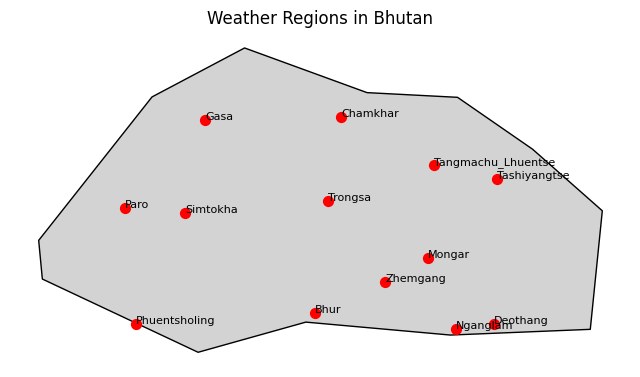

In [4]:
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
import time

# List of regions
regions = sheet_names

# Geocode each region
geolocator = Nominatim(user_agent="bhutan-region-mapper")
locations = []
for name in regions:
    try:
        location = geolocator.geocode(f"{name}, Bhutan")
        if location:
            locations.append({
                "Region": name,
                "Latitude": location.latitude,
                "Longitude": location.longitude
            })
        else:
            locations.append({"Region": name, "Latitude": None, "Longitude": None})
    except:
        locations.append({"Region": name, "Latitude": None, "Longitude": None})
    time.sleep(1)

# Convert to DataFrame
df = pd.DataFrame(locations)

# ✅ Manual fixes for missing regions
manual_fixes = {
    "Tashiyangtse": (27.6156, 91.4921),
    "Tangmachu_Lhuentse": (27.6864, 91.1260)
}

for region, (lat, lon) in manual_fixes.items():
    df.loc[df['Region'] == region, 'Latitude'] = lat
    df.loc[df['Region'] == region, 'Longitude'] = lon

# Drop rows that still have missing coordinates (optional)
df = df.dropna(subset=['Latitude', 'Longitude'])

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs="EPSG:4326")

# Load shapefile
world = gpd.read_file("../world_boundaries_for_bhutan_map/ne_110m_admin_0_countries.shp")

# Plot Bhutan map
ax = world[world["ADMIN"] == "Bhutan"].plot(color='lightgrey', edgecolor='black', figsize=(8, 8))

# Plot geocoded region points
gdf.plot(ax=ax, color='red', markersize=50)

# Add region labels
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf['Region']):
    ax.text(x, y, label, fontsize=8)

plt.title("Weather Regions in Bhutan")
plt.axis("off")
plt.show()


In [5]:
# Final coordinate table
region_coords = df[['Region', 'Latitude', 'Longitude']].copy().reset_index(drop=True)
region_coords.to_csv(os.path.join(output_dir, "region_coordinates.csv"), index=False)
print(region_coords)

                Region   Latitude  Longitude
0                 Paro  27.464637  89.318341
1                 Gasa  27.919087  89.787532
2             Deothang  26.862579  91.473084
3                 Bhur  26.919497  90.430896
4             Nganglam  26.836339  91.251614
5             Zhemgang  27.082115  90.840898
6             Simtokha  27.440233  89.671027
7        Phuentsholing  26.863961  89.383736
8             Chamkhar  27.937078  90.581878
9               Mongar  27.206509  91.090036
10             Trongsa  27.501613  90.507595
11        Tashiyangtse  27.615600  91.492100
12  Tangmachu_Lhuentse  27.686400  91.126000


### Clean data, summarize missing values, and check RH availability

- Load and clean raw meteorological data for each region.
- Standardize column names (e.g., `T max` → `Tmax`).
- Save cleaned DataFrames as `.pkl` files for future use.
- Summarize the number of rows and missing values in key columns.
- Identify which regions include **Relative Humidity (RH)** data.


In [6]:
# Setup
summary = []

for sheet in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet)
    n_rows = len(df)

    # Clean column names
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace('T max', 'Tmax', regex=False)
    df.columns = df.columns.str.replace('T min', 'Tmin', regex=False)

    # Create Date column
    if all(col in df.columns for col in ['Year', 'Month', 'Day']):
        df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']], errors='coerce')

    # Convert numeric columns
    for col in ['Rainfall', 'Tmax', 'Tmin', 'RH']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Save cleaned data as pickle
    df.to_pickle(os.path.join(output_dir, f"{sheet}.pkl"))

    # Count missing values
    missing_counts = df.isna().sum()
    row = {
        'Region': sheet,
        'Num Rows': n_rows,
        'Has RH': 'RH' in df.columns
    }
    for col in missing_counts.index:
        row[f'Missing {col}'] = missing_counts[col]
    
    summary.append(row)

# Save summary
df_summary = pd.DataFrame(summary)
df_summary.to_csv(os.path.join(output_dir, "summary.csv"), index=False)

# Optional: preview summary in notebook
pd.set_option('display.max_columns', None)
df_summary


,Region,Num Rows,Has RH,Missing Year,Missing Month,Missing Day,Missing Rainfall,Missing Tmax,Missing Tmin,Missing Date,Missing RH
0,Paro,9283,False,0,0,0,46,53,65,0,NaN
1,Gasa,8217,False,0,0,0,162,169,169,0,NaN
2,Deothang,9283,True,0,0,0,44,75,75,0,44.0
3,Bhur,9283,True,0,0,0,91,103,102,0,85.0
4,Nganglam,7456,True,0,0,0,733,659,656,0,595.0
5,Zhemgang,9283,True,0,0,0,11,1,0,0,93.0
6,Simtokha,9283,True,0,0,0,23,26,22,0,31.0
7,Phuentsholing,9283,True,0,0,0,807,777,774,0,1001.0
8,Chamkhar,9283,False,0,0,0,5,2,2,0,NaN
9,Kanglung_Tashigang,9283,False,0,0,0,5,7,5,0,NaN


### 📊 Summary of MET Dataset by Region

- All regions include `Rainfall`, `Tmax`, and `Tmin` (with standardized column names).
- Date information (`Year`, `Month`, `Day`, `Date`) is complete across all regions.
- Most regions have ~9,283 rows, though a few (e.g., Gasa, Nganglam, Tangmachu_Lhuentse) have shorter records.

#### 🌧 Rainfall & 🌡 Temperature
- Some regions (e.g., Phuentsholing, Trongsa, Nganglam) show notable missing data in rainfall and temperature.
- Others (e.g., Zhemgang, Mongar) have minimal or no missing values and may be more reliable for analysis.

#### 💧 Relative Humidity (RH)
- RH is available in 7 out of 14 regions.
- Missing RH values are common in some (e.g., Phuentsholing), while others are mostly complete.